# Text summarization (Extractive)

An usupervised model to summarize the text article. The method uses LSA (Latent semantic analysis to find the best semantic sentences in the article.

This notebook implements a TextAnalyzer class which take a text document and displyas three analysis on it.

* Word cloud of Noun
* Bar graph of frequent words
* Bar graph of frequent nouns
* Summary of article ( Implemented using LSA technique )


In [198]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from itertools import cycle
import numpy as np
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MeanShift, estimate_bandwidth,KMeans
from wordcloud import WordCloud, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer,sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from gensim.summarization import summarize

[nltk_data] Downloading package stopwords to /home/rahul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rahul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [144]:
path = "/home/rahul/Desktop/SVD_summarizer/4.txt"
STOPWORDS = set(stopwords.words('english'))
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
punctuations = set(string.punctuation)
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

## Utility functions

In [145]:
def read_text(path):
    file = open(path,'r+')
    corpus = file.read()
    return corpus

In [146]:
def clean_text(text):
    text = text.lower()
    #sentwords = word_tokenize(text)
    sentwords = tokenizer.tokenize(text)
    words = [sentword for sentword in sentwords if sentword not in punctuations ]
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if len(word) >= 2]
    text = ' '.join([word for word in words if word not in stopwords.words('english')])
    #print(text)
    return text

In [147]:
### Get the frequency of each of words #####
def word_frequency(text):
    corpus = sent_tokenize(text)
    
    words = []
    sentences = [clean_text(i) for i in corpus]
    for sent in sentences:
        word = sent.split(' ')
        words += word
        
    return dict(Counter(words))   

In [148]:
def term_document_matrix(corpus):
    vec = TfidfVectorizer(input = corpus, ngram_range=(1, 2))
    matrix = vec.fit_transform(corpus)
    return matrix   

In [195]:
class TextAnalyzer(object):
    def __init__(self,text=None):
        self.text = text
        
        
    def Visualize_word_cloud(self):
        text = self.text
        text = nltk.Text(tokens)
        tags = nltk.pos_tag(text)
        
        nouns = [i for i,j in tags if j=='NN']
        nouns_freq = dict(Counter(nouns))
        
        wordcloud = WordCloud().generate_from_frequencies(nouns_freq)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

        # lower max_font_size
        wordcloud = WordCloud(max_font_size=35).generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
    def Visualize_top_frequent_word_count(self,top_n_percent):
        text = self.text
        word_freq = word_frequency(text)
        top_1_percent = int(len(word_freq)*(top_n_percent/100.0))
        top_words = sorted(word_freq.items(),key=lambda x: x[1],reverse=True)[:top_1_percent]
        frequent_word = [i[0] for i in top_words]
        frequency = [i[1] for i in top_words]

        fig, ax = plt.subplots(figsize=(7,5))
        sns.barplot(frequency,frequent_word,ax = ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title('Most frequent words')
        plt.show()
        
        
    def Visualize_top_frequent_nouns(self,top_n_percent):
        text = self.text
        tokens = nltk.word_tokenize(text.lower())
        text = nltk.Text(tokens)
        tags = nltk.pos_tag(text)

        tags = nltk.pos_tag(text)
        nouns = [i for i,j in tags if j=='NN']
        nouns_freq = dict(Counter(nouns))
        slice = int(len(nouns)*(top_n_percent/100.0))
        freq_nouns = sorted(nouns_freq.items(),key=lambda x: x[1], reverse=True)[:slice]
        top_noun_words = [i[0] for i in freq_nouns]
        top_noun_frequency = [i[1] for i in freq_nouns]

        fig, ax = plt.subplots(figsize=(7,5))
        sns.barplot( top_noun_frequency,top_noun_words,ax = ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title('Most frequent nouns in the corpus')
        plt.show()

    def Visualize_corpus(self):
        text = self.text
        corpus = sent_tokenize(text)
        decomposer = TruncatedSVD(n_components=3,random_state=0)
        tdm = term_document_matrix(corpus)
        reduced = decomposer.fit_transform(tdm)
        x,y,z = reduced.T
        fig, ax = plt.subplots( figsize=(7, 5))
        ax = Axes3D()
        ax.scatter(x,y,z,edgecolor='k')
        ax.set_title('Document Visualization ')
        plt.title('Document Visualiszation')
        plt.show()

            

        
    def summarize(self,max_words):
        text = self.text
        corpus = sent_tokenize(text)
        
        tdm = term_document_matrix(corpus)
        u, sigma, v_t = np.linalg.svd(tdm.toarray().T, full_matrices = True)
        max_cols = v_t.argmax(axis = 1)
        included = set()
        summarised_sent = []
        summary = []
        
        already_included = set()
        totalWords = 0
        selected = []

        for i in max_cols:
            
            if i not in already_included:
                already_included.add(i)
                selected.append((i, corpus[i])) # stash the index of the sentence as well
                totalWords += len(corpus[i].split(' '))
                if totalWords > max_words:
                    break
    
        
        return [s[1] for s in sorted(selected, key=lambda x: x[0])]
    
    

In [196]:
text = read_text(path)

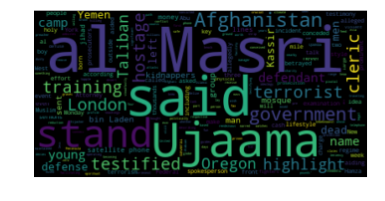

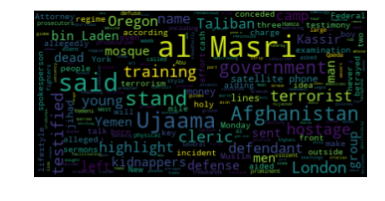

In [197]:
Anly = TextAnalytics(text)
Anly.Visualize_word_cloud()

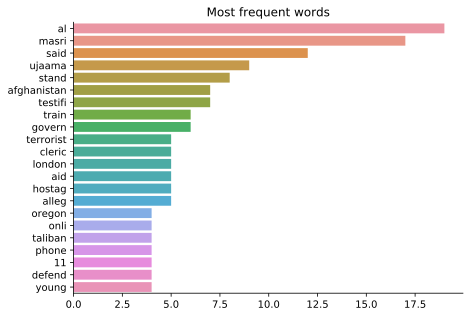

In [173]:
Anly.Visualize_top_frequent_word_count(5)

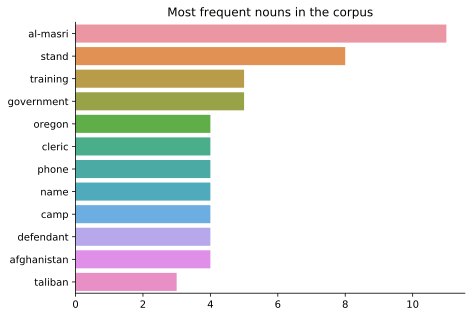

In [174]:
Anly.Visualize_top_frequent_nouns(5)

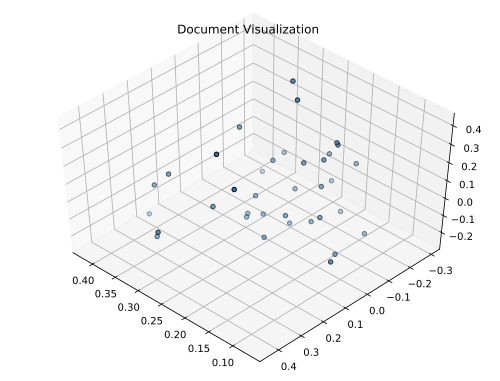

In [175]:
Anly.Visualize_corpus()

In [169]:
Anly.summarize(max_words=100)

['"I wish I trained my son," the woman said.',
 '"It looks just like Afghanistan," Ujaama wrote to the prominent preacher, asking for trainers in both the physical and spiritual aspects of holy war to be sent from London so fighters could be readied for the Afghanistan front lines.',
 'Prosecutors also allege that al-Masri sent Ujaama to Afghanistan in 1999 to deliver envelopes of cash and a young recruit for the front lines.',
 'Federal prosecutors have also alleged that al-Masri aided kidnappers of a large tour group in Yemen in 1998 and called to the stand two survivors of the harrowing hostage drama that left four of their fellow travelers dead.']